In [52]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model

In [53]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [54]:
train_images.shape

(60000, 28, 28)

In [55]:
test_images.shape

(10000, 28, 28)

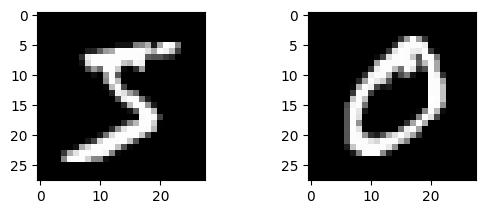

In [60]:
plt.subplot(221)
plt.imshow(train_images[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(train_images[1], cmap=plt.get_cmap('gray'))

plt.show()

In [37]:

train_images, test_images = train_images / 255.0, test_images / 255.0

In [39]:
def add_noise(images, noise_factor=0.3):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape) 
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

noisy_train_images = add_noise(train_images)
noisy_test_images = add_noise(test_images)


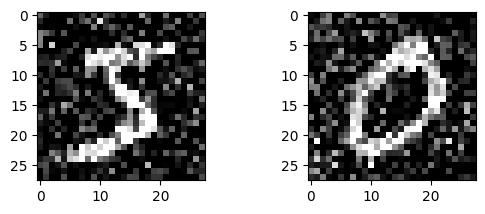

In [61]:
plt.subplot(221)
plt.imshow(noisy_train_images[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(noisy_train_images[1], cmap=plt.get_cmap('gray'))
plt.show()

In [41]:
input_img = Input(shape=(28, 28, 1)) 

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          9248

In [42]:

noisy_train_images = noisy_train_images.reshape((-1, 28, 28, 1))
noisy_test_images = noisy_test_images.reshape((-1, 28, 28, 1))
train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))


In [43]:
autoencoder.fit(noisy_train_images, train_images,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(noisy_test_images, test_images))


Epoch 1/10

235/235 [==============================] - 29s 116ms/step - loss: 0.1932 - val_loss: 0.1019
Epoch 2/10
235/235 [==============================] - 32s 136ms/step - loss: 0.0973 - val_loss: 0.0920
Epoch 3/10
235/235 [==============================] - 29s 124ms/step - loss: 0.0910 - val_loss: 0.0881
Epoch 4/10
235/235 [==============================] - 31s 133ms/step - loss: 0.0880 - val_loss: 0.0862
Epoch 5/10
235/235 [==============================] - 31s 130ms/step - loss: 0.0861 - val_loss: 0.0844
Epoch 6/10
235/235 [==============================] - 33s 141ms/step - loss: 0.0848 - val_loss: 0.0833
Epoch 7/10
235/235 [==============================] - 30s 130ms/step - loss: 0.0837 - val_loss: 0.0826
Epoch 8/10
235/235 [==============================] - 36s 155ms/step - loss: 0.0830 - val_loss: 0.0818
Epoch 9/10
235/235 [==============================] - 35s 147ms/step - loss: 0.0823 - val_loss: 0.0816
Epoch 10/10
235/235 [==============================] - 31s 133ms/step - 

313/313 [==============================] - 2s 5ms/step


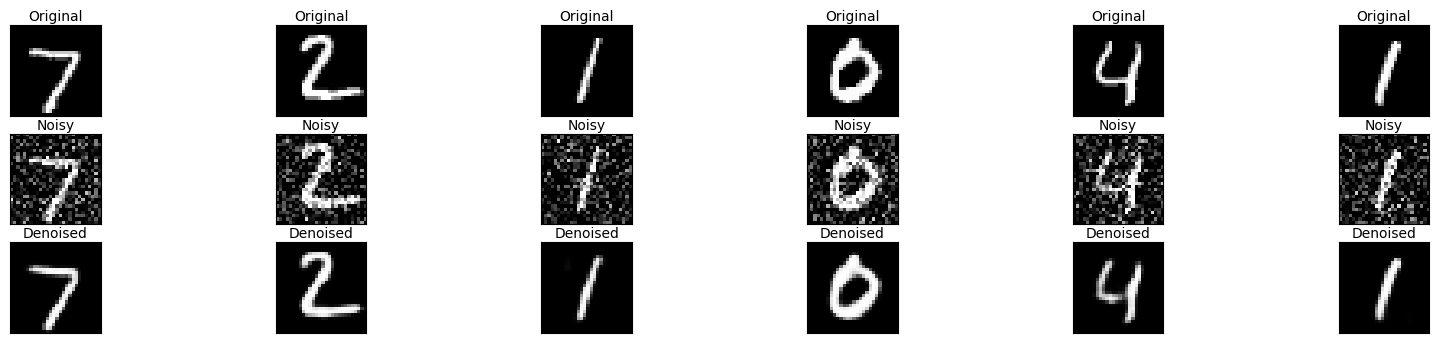

In [62]:
def display_images(orig, noisy, denoised):
    n = 6  
    plt.figure(figsize=(20, 4))
    
    for i in range(n):
        
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(orig[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.text(0.5, 1.05, 'Original', horizontalalignment='center', transform=ax.transAxes)

       
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.text(0.5, 1.05, 'Noisy', horizontalalignment='center', transform=ax.transAxes)

        
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.text(0.5, 1.05, 'Denoised', horizontalalignment='center', transform=ax.transAxes)
    plt.show()

denoised_images = autoencoder.predict(noisy_test_images)

display_images(test_images, noisy_test_images, denoised_images)


In [66]:
from sklearn.metrics import mean_squared_error
from math import log10, sqrt

def calculate_psnr(original, denoised):
    mse = mean_squared_error(original.flatten(), denoised.flatten())
    if mse == 0:
        return float('inf')
    return 20 * log10(1.0 / sqrt(mse))

psnr_list = []
for i in range(10):
    psnr = calculate_psnr(test_images[i], denoised_images[i])
    psnr_list.append(psnr)

for i, psnr_value in enumerate(psnr_list):
    print(f"Image {i+1} PSNR: {psnr_value:.2f} dB")

avg_psnr = sum(psnr_list) / len(psnr_list)
print(f"\nAverage PSNR for the first 10 test images: {avg_psnr:.2f} dB")


Image 1 PSNR: -36.88 dB
Image 2 PSNR: -39.03 dB
Image 3 PSNR: -34.03 dB
Image 4 PSNR: -40.29 dB
Image 5 PSNR: -37.03 dB
Image 6 PSNR: -35.83 dB
Image 7 PSNR: -37.45 dB
Image 8 PSNR: -37.59 dB
Image 9 PSNR: -39.35 dB
Image 10 PSNR: -39.41 dB

Average PSNR for the first 10 test images: -37.69 dB


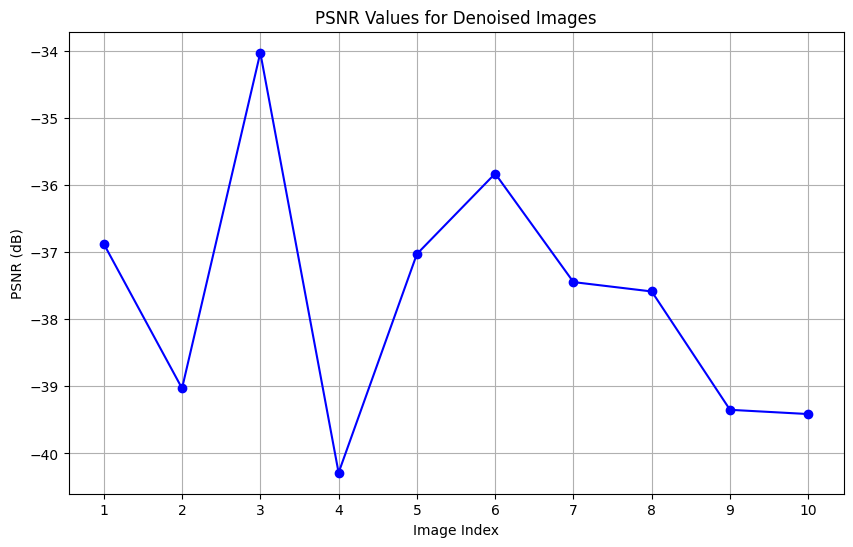

In [67]:
image_indices = range(1, 11)  

plt.figure(figsize=(10, 6))
plt.plot(image_indices, psnr_list, marker='o', linestyle='-', color='b')
plt.title('PSNR Values for Denoised Images')
plt.xlabel('Image Index')
plt.ylabel('PSNR (dB)')
plt.xticks(image_indices)
plt.grid(True)
plt.show()